# Initializatoin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/deep/A3

/content/drive/MyDrive/deep/A3


## Imports

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [ ]:
dataset = Dataset()

for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Files already exist, skipping download and extraction.
category = Polish - random name = Kozlow
category = Scottish - random name = Kerr
category = Czech - random name = Wykruta
category = Czech - random name = Jindra
category = Italian - random name = Ragno
category = Portuguese - random name = Ventura
category = German - random name = Blumenthal
category = Irish - random name = Seaghdha
category = Spanish - random name = Castell
category = Japanese - random name = Yoshihara


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        #your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # self.softmax = F.softmax

    def forward(self, input, hidden):

        #your_code
        combined = torch.cat((input, hidden),1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        # output =  self.softmax(output,1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
#your_code
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    #your_code
    n = name_tensor.shape[1]
    output = None
    for i in range(n):
      output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.9302 Chau is predicted as a "Chinese" name, status = ✗ (Vietnamese)
10000 10% 2.9192 Haddad is predicted as a "Dutch" name, status = ✗ (Arabic)
15000 15% 2.8691 Wright is predicted as a "Greek" name, status = ✗ (Scottish)
20000 20% 2.8961 Annan is predicted as a "Scottish" name, status = ✗ (English)
25000 25% 2.8170 Huramshin is predicted as a "Russian" name, status = ✓
30000 30% 2.9073 Giolla is predicted as a "German" name, status = ✗ (Irish)
35000 35% 2.9273 Shiomiya is predicted as a "Polish" name, status = ✗ (Japanese)
40000 40% 2.8093 Wright is predicted as a "German" name, status = ✗ (Scottish)
45000 45% 2.7927 Janowski is predicted as a "Korean" name, status = ✗ (Polish)
50000 50% 2.9610 Sheehy is predicted as a "Polish" name, status = ✗ (Irish)
55000 55% 2.8137 Holodilin is predicted as a "Russian" name, status = ✓
60000 60% 2.8741 Kwang  is predicted as a "Greek" name, status = ✗ (Korean)
65000 65% 2.8835 Gordon is predicted as a "German" name, status = ✗ (Scottish)

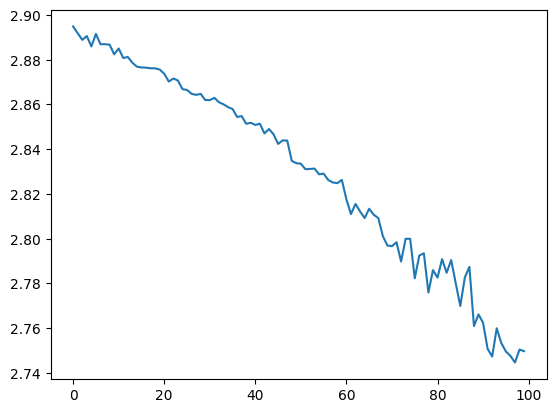

In [ ]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for itera in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if itera % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (itera, itera / n_iters * 100, loss, line, guess, correct))

    if itera % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.0826
Epoch [20/100], Loss: 0.9980
Epoch [30/100], Loss: 0.9109
Epoch [40/100], Loss: 0.8170
Epoch [50/100], Loss: 0.7148
Epoch [60/100], Loss: 0.6049
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.3754
Epoch [90/100], Loss: 0.2737
Epoch [100/100], Loss: 0.1927


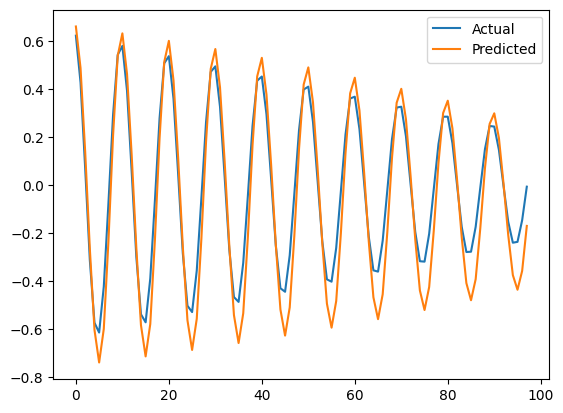

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [ ]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.squeeze(0).t())
                               ]),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.squeeze(0).t())
                               ]))


batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
inp, targ = next(iter(train_loader))
inp.shape

torch.Size([128, 28, 28])

## LSTM Cells

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: (batch_size, input_size)
        #       hx: (batch_size, hidden_size)
        # Outputs:
        #       hy: (batch_size, hidden_size)
        #       cy: (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        # your code
        gates = self.xh(input) + self.hh(hx) + self.bias
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = (cx * f_t) + i_t * g_t
        hy = o_t * torch.tanh(cy)

        return (hy, cy)

## LSTM Models

In [ ]:
layer = 3
batch_size = 10
hidden_dim = 56

A = torch.zeros(layer, batch_size, hidden_dim)
print(A.shape)
h = torch.stack([torch.zeros(batch_size, hidden_dim) for _ in range(layer)])
print(h.shape)


torch.Size([3, 10, 56])
torch.Size([3, 10, 56])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstms = nn.ModuleList([
            nn.LSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(layer_dim)
        ])


        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros
        h = [torch.zeros(x.size(0), self.hidden_dim, device=x.device) for _ in range(self.layer_dim)]
        c = [torch.zeros(x.size(0), self.hidden_dim, device=x.device) for _ in range(self.layer_dim)]
        # cn = c0[0,:,:]
        # hn = h0[0,:,:]
        # outs = []

        for seq in range(x.size(1)):
            input = x[:, seq, :]
            for layer in range(self.layer_dim):
              h[layer] , c[layer] = self.lstms[layer](input, (h[layer] , c[layer] ))
              input = h[layer]


        #your code
        out = self.fc(h[-1])
        return out

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# your code
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# your code
itterations = 0
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        itterations += 1

        if (itterations + 1) % 500 == 0:
            avg_loss = total_loss / 500
            accuracy = 100 * correct / total
            print(f"Epoch [{epoch+1}], Step [{i+1}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Train model and print Loss and Accuracy on Test Dataset after each 500 iterations

Epoch [2], Step [469], Loss: 0.0021, Accuracy: 98.98%
Epoch [3], Step [469], Loss: 0.0033, Accuracy: 99.03%
Epoch [4], Step [469], Loss: 0.0057, Accuracy: 99.10%
Epoch [5], Step [469], Loss: 0.0072, Accuracy: 99.09%


In [ ]:
# Set model to eval mode
model.eval()

# Get a random batch
dataiter = iter(test_loader)  # or val_loader if you have one
images, labels = next(dataiter)

# Move to the same device as model
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
  outputs = model(images)
  preds = outputs.argmax(dim=1)



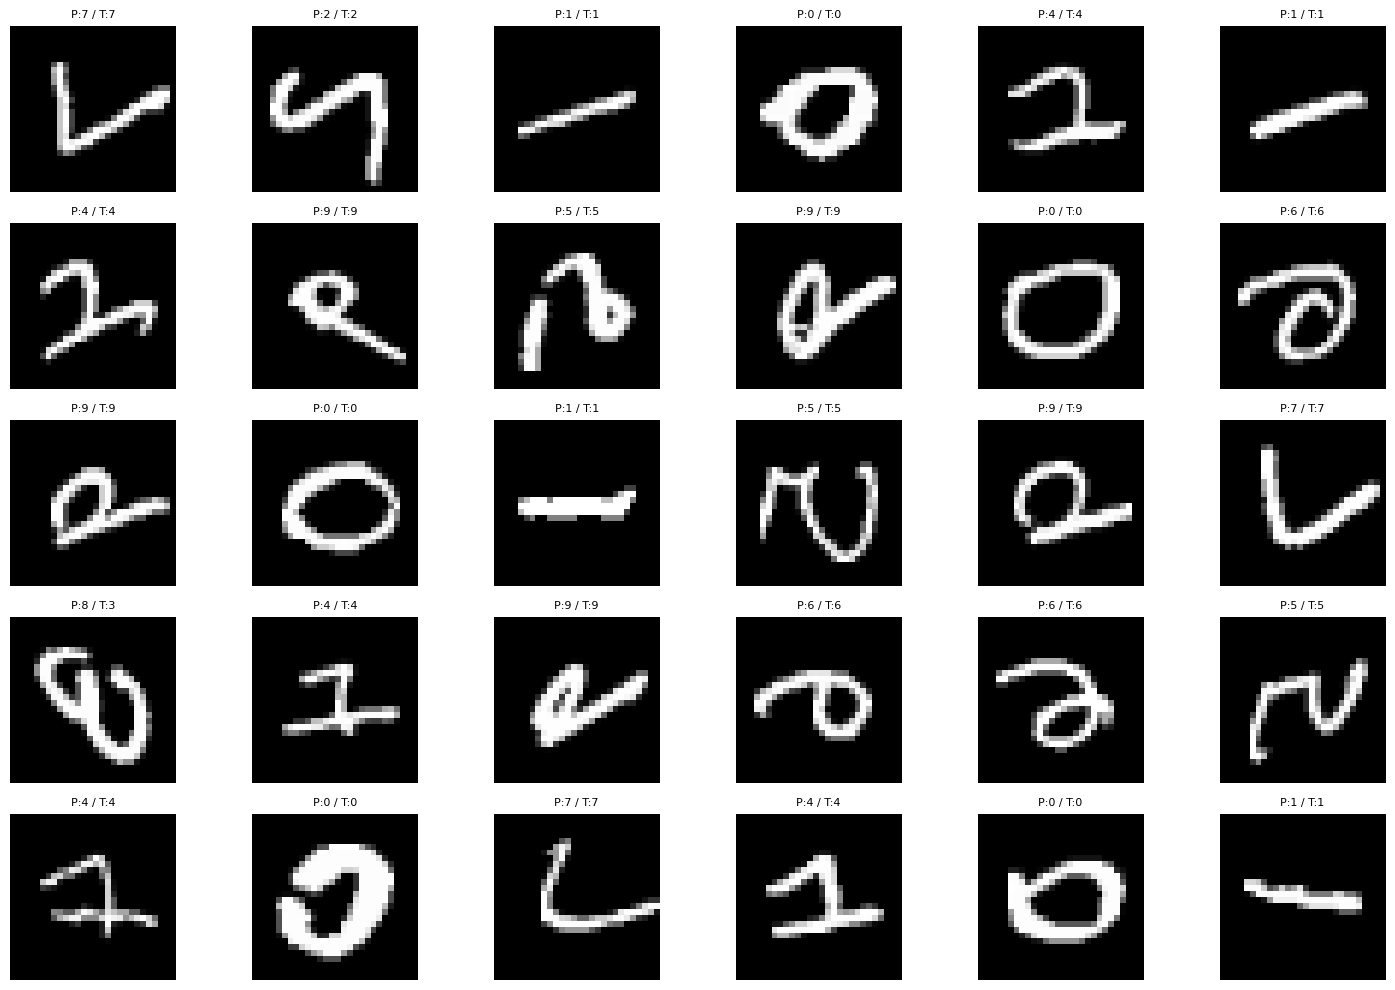

In [ ]:
num_images = 30
rows, cols = 5, 6
plt.figure(figsize=(15, 10))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    img = images[i].cpu()
    plt.imshow(img, cmap='gray')


    plt.title(f'P:{preds[i].item()} / T:{labels[i].item()}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to eval mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)  # sum loss over batch

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy


test_loss, test_acc = evaluate_model(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.0707, Test Accuracy: 98.03%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [ ]:
import pandas as pd


df = pd.read_csv('IMDB/IMDB.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import re
import string

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)  # Remove HTML
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Lowercase
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['tokens'] = df['clean_review'].apply(lambda x: x.split())


In [ ]:
from collections import Counter
max_len = 200


# Count word frequencies
all_tokens = [token for sublist in df['tokens'].tolist() for token in sublist]
vocab = Counter(all_tokens)

# Keep top N words
vocab_size = 10000
most_common = vocab.most_common(vocab_size - 2)
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<OOV>"] = 1

def encode_tokens(tokens, word2idx):
    return [word2idx.get(token, word2idx["<OOV>"]) for token in tokens]

df['encoded'] = df['tokens'].apply(lambda tokens: encode_tokens(tokens, word2idx))

def pad_sequence(seq, max_len):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [word2idx["<PAD>"]] * (max_len - len(seq))

df['padded'] = df['encoded'].apply(lambda x: pad_sequence(x, max_len))


df.head()

,review,sentiment,clean_review,tokens,encoded,padded
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[28, 5, 2, 78, 1929, 43, 1058, 12, 101, 145, 4...","[28, 5, 2, 78, 1929, 43, 1058, 12, 101, 145, 4..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[4, 383, 114, 358, 2, 1352, 2986, 7, 51, 1, 51...","[4, 383, 114, 358, 2, 1352, 2986, 7, 51, 1, 51..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[10, 192, 11, 13, 4, 383, 97, 6, 1105, 59, 20,...","[10, 192, 11, 13, 4, 383, 97, 6, 1105, 59, 20,..."
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[684, 222, 4, 235, 113, 4, 114, 436, 3618, 118...","[684, 222, 4, 235, 113, 4, 114, 436, 3618, 118..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[1, 1, 110, 8, 2, 59, 5, 290, 7, 4, 2141, 1369...","[1, 1, 110, 8, 2, 59, 5, 290, 7, 4, 2141, 1369..."


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


X_train, X_test, y_train, y_test = train_test_split(df['padded'].tolist(), df['sentiment'].map({'positive': 1, 'negative': 0}).tolist(), test_size=0.2, random_state=42)

train_data = IMDBDataset(X_train, y_train)
test_data = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentLSTM(vocab_size=10000, embed_dim=128, hidden_dim=128, output_dim=2, n_layers=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for reviews, labels in train_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(reviews)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


    print(f"Epoch {epoch+1}/{num_epochs}, avgLoss: {total_loss / len(train_loader)}, accuracy:{ correct / total}")


Epoch 1/5, avgLoss: 0.6909339583396912, accuracy:0.5203
Epoch 2/5, avgLoss: 0.6914101461410522, accuracy:0.5209
Epoch 3/5, avgLoss: 0.6347292330265045, accuracy:0.6089
Epoch 4/5, avgLoss: 0.36320330619812013, accuracy:0.846625
Epoch 5/5, avgLoss: 0.27522725404500964, accuracy:0.891175


In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for reviews, labels in test_loader:
            reviews = reviews.to(device)
            labels = labels.to(device)

            outputs = model(reviews)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

avg_loss, accuracy = evaluate(model, test_loader, criterion, device)
print(f"avgLoss: {avg_loss}, accuracy:{accuracy}")

avgLoss: 0.31109290783572346, accuracy:0.8742
